S0 :: Imports

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

_DATAEXTR_DIR = "../dataExtracted"

S1 :: Load dataframes

In [13]:
mode = 'connectivity'
status = 'random'

avgConnectivityDf = pd.read_csv(str(_DATAEXTR_DIR + f"/avg_{mode}_{status}.csv"))
ConnDf = (avgConnectivityDf / avgConnectivityDf.iloc[0]).copy()
ConnDf

,1015,1062,1063,1072,1088,113,116,1168,1170,1185,...,Metanode 83,Metanode 87,Metanode 9,Metanode 90,Metanode 91,Metanode 92,Metanode 93,Metanode 94,Metanode 96,Metanode 99
0,1.0,1.00000,1.0,1.00000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,...,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000
1,1.0,1.00000,1.0,1.00000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,...,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000
2,1.0,1.00000,1.0,1.00000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,...,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000
3,1.0,1.00000,1.0,1.00000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,...,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000
4,1.0,1.00000,1.0,1.00000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,...,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,0.0,0.00716,0.0,0.00716,0.006829,0.181706,0.505665,0.0,0.0,0.233463,...,0.0,0.476058,0.410683,0.293928,0.497237,0.410683,0.496200,0.0,0.377070,0.477154
729,0.0,0.00716,0.0,0.00716,0.006829,0.181706,0.505665,0.0,0.0,0.233463,...,0.0,0.476058,0.410683,0.293928,0.497237,0.410683,0.496200,0.0,0.377070,0.477154
730,0.0,0.00716,0.0,0.00716,0.006829,0.181706,0.505665,0.0,0.0,0.233463,...,0.0,0.476058,0.410683,0.293928,0.497237,0.410683,0.496200,0.0,0.377070,0.477154
731,0.0,0.00716,0.0,0.00716,0.006829,0.181706,0.505665,0.0,0.0,0.233463,...,0.0,0.476058,0.410683,0.293928,0.497237,0.410683,0.496200,0.0,0.377070,0.477154


S3 :: Function to filter dataset for relevant iterations and only top 10

In [14]:
def get_top10(n, relative= True):
    
    # set start of the slicing
    start = n-30
    
    if relative:
        ConnDf = (avgConnectivityDf / avgConnectivityDf.iloc[0]).copy()
    else:
        ConnDf = avgConnectivityDf.copy()

    # only get data for chosen period
    idx = list(range(start, n))
    conn_df = pd.DataFrame(ConnDf.loc[idx])

    # sort by the last relevant iteration so that the legend is in order
    return conn_df.T.sort_values(by= n-1, axis= 0, ascending= False)

S4 :: Map each country to a specific color

In [15]:
columns = avgConnectivityDf.columns
colors = sns.color_palette("turbo", len(columns))

col_dict = {columns[i] : colors[i] for i in range(len(columns))}

S5 :: Interaction !!

interactive(children=(IntSlider(value=30, description='Iteration window', max=733, min=30), Checkbox(value=Tru…

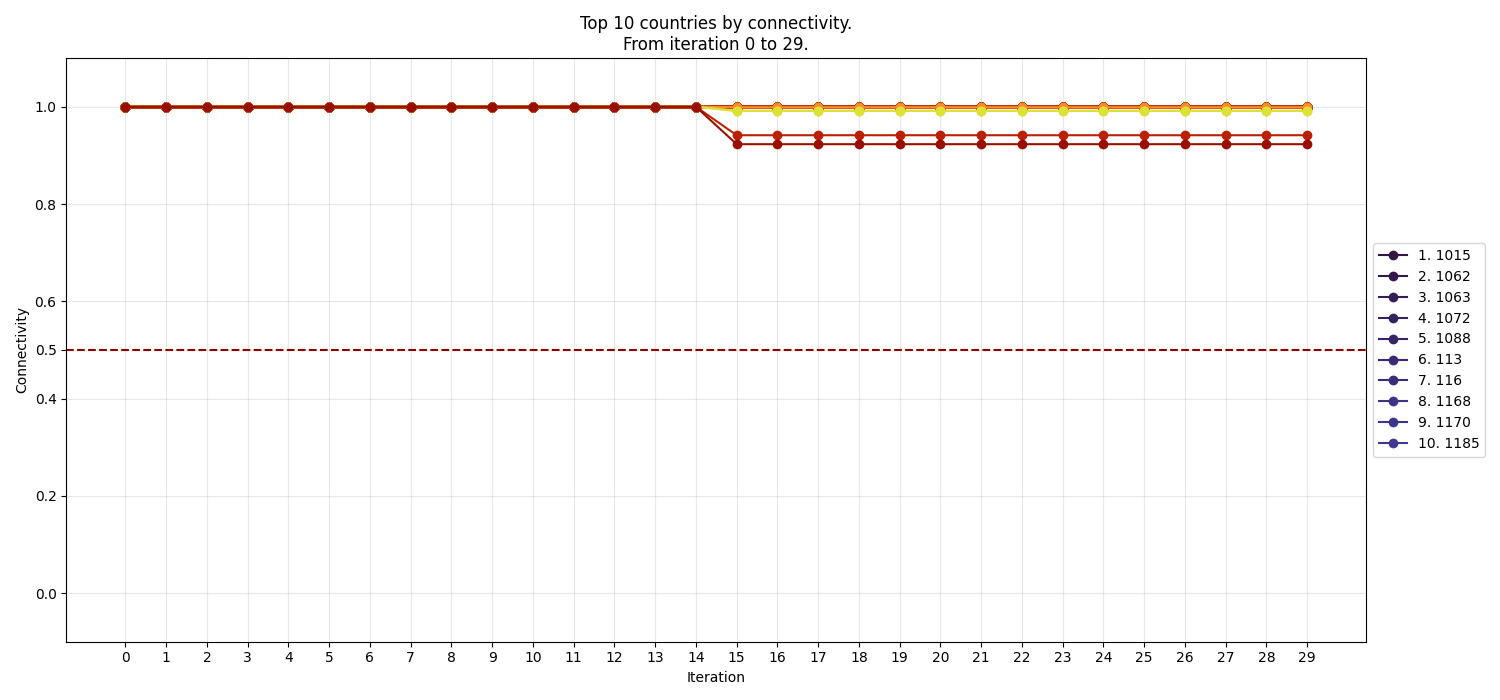

In [16]:
%matplotlib widget

fig, ax = plt.subplots(figsize= (15, 7))

def update_plot(n, relative= True):

    # get entries    
    conn_df = get_top10(n, relative)
    
    # set start
    start = n-30

    ax.clear()
    ax.grid(alpha= 0.3)
    
    # keep track of minimum connectivity to adjust graph lims
    min_pos_conn = np.inf

    # plot lines
    idx = list(range(start, n))
    for i, (_, r) in enumerate(conn_df.iterrows()):

        # use top10 of final iteration to label countries
        if i < 10:

            # update min conn if needed
            min_conn_row = r.values.min()
            if (min_conn_row <= min_pos_conn):
                min_pos_conn = min_conn_row

            l = f"{i+1}. {r.name}" 
        
        # no label for countries outside of the top10
        else:
            l = None

        ax.plot(list(range(len(idx))), r.values, marker= 'o', label= l, c= col_dict[r.name])
    

    ax.set_xticks(list(range(len(idx))), idx)

    if relative:
        ax.set_ylim(-0.1, 1.1)
        ax.set_yticks([0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0])
        ax.axhline(y= 0.5, linestyle= '--', c= 'darkred') 
    else:
        ax.set_ylim(bottom= min_pos_conn-1)
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

    ax.set_ylabel("Connectivity")
    ax.set_xlabel("Iteration")
    ax.set_title(f"Top 10 countries by connectivity.\nFrom iteration {start} to {n-1}.")
    
    fig.tight_layout()
    fig.canvas.draw_idle()


n_slider = widgets.IntSlider(value= 30, min= 30, max= len(avgConnectivityDf), step= 1, description= 'Iteration window')

interact(update_plot, n= n_slider)
plt.show()